**Table of contents**<a id='toc0_'></a>    
- [MNIST digit classification problem — NN](#toc1_)    
  - [Parameters and constants](#toc1_1_)    
  - [Setup mlflow for experiment tracking](#toc1_2_)    
  - [Load the dataset](#toc1_3_)    
  - [Model 2: Fully connected neural net](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[MNIST digit classification problem — NN](#toc0_)

Attempting the digit classification problem with a fully connected neural net.


In [3]:
import os
import pathlib
import pickle

import mlflow
import mlflow.sklearn
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split

/home/shikhar/.pyenv/versions/3.10.6/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <a id='toc1_1_'></a>[Parameters and constants](#toc0_)

In [4]:
TRAIN_SET_SIZE = 50_000
SPLIT_SEED = 123
EXPERIMENT_DIR = pathlib.Path('/data/kaggle/mnist')

## <a id='toc1_2_'></a>[Setup mlflow for experiment tracking](#toc0_)

In [5]:
mlflow.set_tracking_uri("https://mlflow.tenzing.shkhr.ovh")
# experiment_id = mlflow.create_experiment('mnist-digits', artifact_location='s3://mlflow/mnist')
experiment = mlflow.set_experiment('mnist-digits')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'https://minio-api.tenzing.shkhr.ovh'

## <a id='toc1_3_'></a>[Load the dataset](#toc0_)

Load the MNIST dataset and generate the train, validation and test splits and view a few random training samples.

In [6]:
dataset = load_dataset('mnist')
train_set, validation_set = train_test_split(dataset['train'], train_size=TRAIN_SET_SIZE, random_state=SPLIT_SEED)
test_set = {'image': list(dataset['test']['image']), 'label': list(dataset['test']['label'])}

Found cached dataset mnist (/home/shikhar/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 42.39it/s]


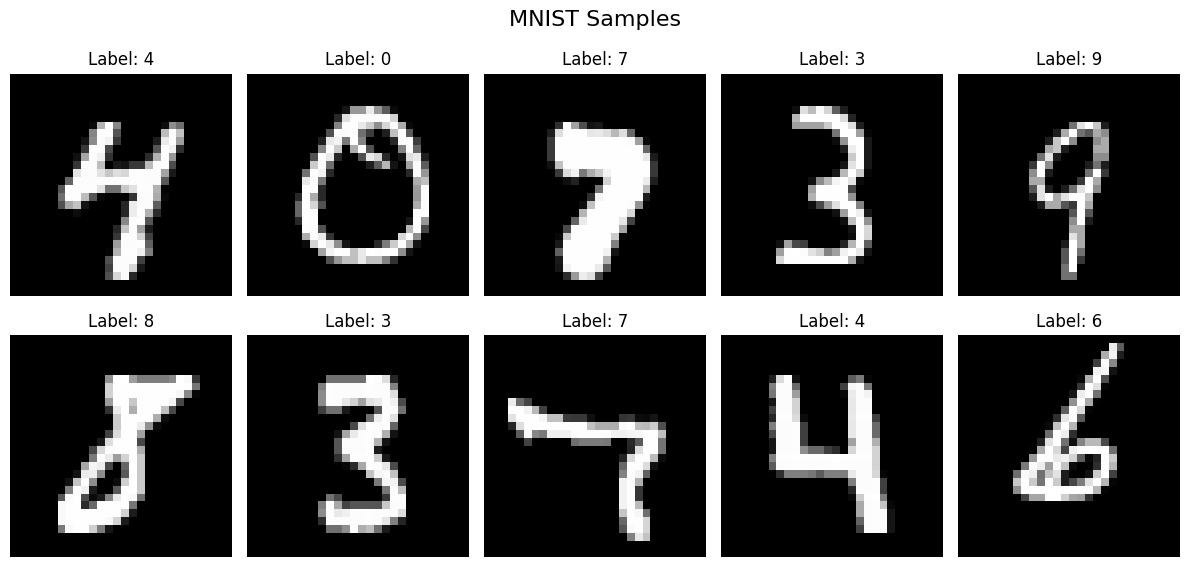

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('MNIST Samples', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    sample_idx = np.random.randint(0, len(train_set['image']))
    sample_image, sample_label = train_set['image'][sample_idx], train_set['label'][sample_idx]

    ax.imshow(sample_image, cmap='gray')
    ax.set_title(f'Label: {sample_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## <a id='toc1_4_'></a>[Model 2: Fully connected neural net](#toc0_)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

from typing import List

In [9]:
class FullyConnectedNet(nn.Module):
    def __init__(self, sizes: List[int]):
        if len(sizes) != 2:
            raise ValueError('Only supports network with 1 hidden layer')

        super(FullyConnectedNet, self).__init__()
        self._fc1 = nn.Linear(784, sizes[0])
        self._fc2 = nn.Linear(sizes[0], sizes[1])
        self._fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self._fc1(x))
        x = torch.relu(self._fc2(x))
        x = self._fc3(x)
        return torch.log_softmax(x, dim=1)

In [72]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the transforms to preprocess the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __getitem__(self, index):
        image = self.data['image'][index]
        label = self.data['label'][index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data['image'])

train_dataset = MNISTDataset(train_set, transform)
validation_dataset = MNISTDataset(validation_set, transform)
test_dataset = MNISTDataset(test_set, transform)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [96]:
# %%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def eval_model(net, loader, criterion):
    net.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            # data = torch.unsqueeze(data, 1)
            output = net(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # Print the results for each epoch
    return accuracy, test_loss

def train_mnist_model(net: nn.Module, criterion: nn.Module, learning_rate: float, epoch_count: int):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)


    for epoch in range(epoch_count):
        net.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            # data = torch.unsqueeze(data, 1)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        accuracy, test_loss = eval_model(net, validation_loader, criterion)
        print(f'Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}')


In [29]:

with mlflow.start_run(run_name='fc-nn', description='Fully connected neural net', experiment_id=experiment.experiment_id) as run:
    net_size = [128, 64]
    learning_rate = 0.002
    epoch_count = 10
    mlflow.log_param("layer_size", net_size)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("epoch_count", 10)
    mlflow.log_param("gpu", "true")

    criterion = nn.CrossEntropyLoss()
    net = FullyConnectedNet(sizes=net_size).to(device)

    train_mnist_model(net, criterion, learning_rate, epoch_count)
    
    model_path = EXPERIMENT_DIR / run.info.run_id / 'model.pkl'
    model_path.parent.mkdir(exist_ok=True)
    torch.save(net.state_dict(), model_path)
    
    mlflow.log_artifact(model_path)

    validation_accuracy, _ = eval_model(net, validation_loader, criterion)
    test_accuracy, _ = eval_model(net, test_loader, criterion)
    mlflow.log_metric('validation_accuracy', validation_accuracy)
    mlflow.log_metric('test_accuracy', test_accuracy)

Epoch 1: Test Loss: 0.0012, Accuracy: 0.95
Epoch 2: Test Loss: 0.0009, Accuracy: 0.96
Epoch 3: Test Loss: 0.0008, Accuracy: 0.97
Epoch 4: Test Loss: 0.0008, Accuracy: 0.97
Epoch 5: Test Loss: 0.0009, Accuracy: 0.97
Epoch 6: Test Loss: 0.0009, Accuracy: 0.97
Epoch 7: Test Loss: 0.0008, Accuracy: 0.97
Epoch 8: Test Loss: 0.0009, Accuracy: 0.97
Epoch 9: Test Loss: 0.0009, Accuracy: 0.97
Epoch 10: Test Loss: 0.0008, Accuracy: 0.98


## Model 3: Convolutional neural net 

In [97]:
class ConvolutionalNeuralNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNet, self).__init__()
        self._conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self._pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self._conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self._fc1 = nn.Linear(7744, 128)
        self._fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self._conv1(x))
        x = self._pool1(x)
        x = torch.relu(self._conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self._fc1(x))
        x = self._fc2(x)

        return torch.log_softmax(x, dim=1)

In [98]:
with mlflow.start_run(run_name='cnn', description='Convolutional neural network', experiment_id=experiment.experiment_id) as run:
    net_size = ['c2d 1,32', 'c2d 32,64', '1600', '128']
    learning_rate = 0.002
    epoch_count = 10
    mlflow.log_param("layer_size", net_size)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("epoch_count", 10)
    mlflow.log_param("gpu", "true")

    criterion = nn.CrossEntropyLoss()
    net = ConvolutionalNeuralNet().to(device)

    train_mnist_model(net, criterion, learning_rate, epoch_count)
    
    model_path = EXPERIMENT_DIR / run.info.run_id / 'model.pkl'
    model_path.parent.mkdir(exist_ok=True)
    torch.save(net.state_dict(), model_path)
    
    mlflow.log_artifact(model_path)

    validation_accuracy, _ = eval_model(net, validation_loader, criterion)
    test_accuracy, _ = eval_model(net, test_loader, criterion)
    mlflow.log_metric('validation_accuracy', validation_accuracy)
    mlflow.log_metric('test_accuracy', test_accuracy)

Epoch 1: Test Loss: 0.0005, Accuracy: 0.98
Epoch 2: Test Loss: 0.0005, Accuracy: 0.98
Epoch 3: Test Loss: 0.0004, Accuracy: 0.99
Epoch 4: Test Loss: 0.0004, Accuracy: 0.99
Epoch 5: Test Loss: 0.0005, Accuracy: 0.99
Epoch 6: Test Loss: 0.0005, Accuracy: 0.99
Epoch 7: Test Loss: 0.0005, Accuracy: 0.99
Epoch 8: Test Loss: 0.0006, Accuracy: 0.99
Epoch 9: Test Loss: 0.0005, Accuracy: 0.99
Epoch 10: Test Loss: 0.0005, Accuracy: 0.99
